In [1]:
from pandas import DataFrame, Grouper
import pandas as pd
import numpy as np
from datetime import datetime
import sys
import world_bank_data as wb
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML


In [2]:
# import our own stuff
sys.path.append("../python/src")

from worldbankApi import get_regionnames, fetch_series, get_all_countries
from tools import read_water_data, extract_features, merge_wbseries_with_oecd_data
from tools import get_oecd_iso3_code_mapping, crs_to_worldbank_countrynames
from waterData import default_features


In [3]:
# set some options
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 600)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

datadir = "../data/"
cachedir = "../data/cache" 

In [4]:
taz_correspondents_countries = tcc = {
    'Jordan': 'JOR',
    'Egypt, Arab Rep.': 'EGY',
    'Uganda': 'UGA',
    'Rwanda': 'RWA',
    'Kenya': 'KEN',
    'Sudan': 'SDN',
    'India': 'IND',
    'Bangladesh': 'BGD',
    'Colombia': 'COL',
    'Bolivia': 'BOL'
}

inverse_taz_correspondents_countries = itcc = {v: k for k, v in taz_correspondents_countries.items()}

mdg_series = {
    'ER.H2O.FWTL.ZS': 'Annual freshwater withdrawals, total (% of internal resources)',
    'ER.H2O.FWTL.K3': 'Annual freshwater withdrawals, total (billion cubic meters)',
    'ER.H2O.FWST.ZS': 'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources',
    'SH.H2O.BASW.ZS': 'People using at least basic drinking water services (% of population)',
    'SG.H2O.TM30.HH.ZS': 'Households with water 30 minutes or longer away round trip (%)',
    'SG.H2O.TL30.HH.ZS': 'Households with water less than 30 minutes away round trip (%)',
    'SG.H2O.PRMS.HH.ZS': 'Households with water on the premises (%)',
    'SH.H2O.SMDW.ZS': 'People using safely managed drinking water services (% of population)',
    'SP.POP.TOTL': 'Population, total',
    'IN.POV.HH.DRNKNGWATER.TOTL.PCT': 'Households Access to Safe Drinking Water - Total (%) (india)', # Country Partnership Strategy for India (FY2013 - 17)
    'IN.POV.HH.DRKNGWATER.WITHIN': 'Availability of drinking water source within the premises (india)',
    'IN.POV.HH.DRKNGWATER.NEAR': 'Availability of drinking water source near the premises (india)',
    'IN.POV.HH.DRKNGWATER.AWAY': 'Availability of drinking water from a source away (india)',
    'IN.POV.HH.DRKNGWATER': 'Total households with drinking water facility (india)',
    'IE.PPN.WATR.CD': 'Public private partnerships investment in water and sanitation (current US$)',
    'IE.PPI.WATR.CD': 'Investment in water and sanitation with private participation (current US$)',
    'IC.WAT.GIFT.ZS': 'Expected to give gifts to get a water connection (% of firms)',
    'IC.FRM.CORR.CORR7': 'Percent of firms expected to give gifts to get a water connection',
    'IC.WAT.DURS': 'Delay in obtaining a water connections (days)',
    'IC.FRM.INFRA.IN6':'Number of water insufficiencies in a typical month',
    'ER.H2O.INTR.PC': 'Renewable internal freshwater resources per capita (cubic meters)',
    'ER.H2O.INTR.K3': 'Renewable internal freshwater resources, total (billion cubic meters)',
    'SI.POV.XPND.MD': 'Median daily per capita income or consumption expenditure (2011 PPP)',
    'SI.SPR.PCAP': 'Survey mean consumption or income per capita, total population (2011 PPP $ per day)',
    'AG.SRF.TOTL.K2': 'Surface area (sq. km)'
}



In [5]:
df = fetch_series(cachedir=cachedir,series=mdg_series,scale=[])
countrynames = get_all_countries(cachedir=cachedir,includeaggs=True)
df.rename(columns=mdg_series,inplace=True)

# the data from oecd must be downloaded and saved as zips in the data-dir, check readme for links
oecddf = read_water_data(setname="fullset",datadir=datadir,cachedir=cachedir)

# the codemapping is generate over the full dataset to get all oecd-country-codes
# and from a fetch of the countries known to worldbank
codemapping = get_oecd_iso3_code_mapping(cachedir=cachedir,datadir=datadir)

Reading Data from cached file: ../data/cache/ER.H2O.FWTL.ZS.p
Reading Data from cached file: ../data/cache/ER.H2O.FWTL.K3.p
Reading Data from cached file: ../data/cache/ER.H2O.FWST.ZS.p
Reading Data from cached file: ../data/cache/SH.H2O.BASW.ZS.p
Reading Data from cached file: ../data/cache/SG.H2O.TM30.HH.ZS.p
Reading Data from cached file: ../data/cache/SG.H2O.TL30.HH.ZS.p
Reading Data from cached file: ../data/cache/SG.H2O.PRMS.HH.ZS.p
Reading Data from cached file: ../data/cache/SH.H2O.SMDW.ZS.p
Reading Data from cached file: ../data/cache/SP.POP.TOTL.p
Reading Data from cached file: ../data/cache/IN.POV.HH.DRNKNGWATER.TOTL.PCT.p
Reading Data from cached file: ../data/cache/IN.POV.HH.DRKNGWATER.WITHIN.p
Reading Data from cached file: ../data/cache/IN.POV.HH.DRKNGWATER.NEAR.p
Reading Data from cached file: ../data/cache/IN.POV.HH.DRKNGWATER.AWAY.p
Reading Data from cached file: ../data/cache/IN.POV.HH.DRKNGWATER.p
Reading Data from cached file: ../data/cache/IE.PPN.WATR.CD.p
Reading

In [6]:
# only tcc-countries - filter by iso3 code
df = df[df['Country'].isin(list(itcc))]

# set 0 to no data
df = df.replace({0.0: np.nan})

oecddf = extract_features(oecddf,features=default_features)
oecddf = oecddf.replace({0.0: np.nan})

In [7]:
# read the historical classification in Incomegroups from the worldbank
icgroup_df = pd.read_csv(datadir+"/OGHIST.csv",header=0,quotechar='"',low_memory=False,sep=";",na_values=['..'])

# the historical data some datapoints
# fill missing values with the value from the next valid year 
# this is a little dirty in code
T = icgroup_df.T
#display(T)
#display(T.describe())
T = T.fillna(method ='backfill') 
#display(T)
#display(T.describe())
icgroup_df = T.T
icgroup_df = icgroup_df.melt(id_vars=('id','Country'),var_name="Year")
#display(icgroup_df.sample())
# replace the values used for classification with the values used by oecd
icgroup_df = icgroup_df.replace({'value': {'L': 'LDCs','LM': 'LMICs', 'UM':'UMICs','H': 'HICs', 'LM*':'LMICs'}})
# give it a nice name
icgroup_df = icgroup_df.rename(columns={'value': 'IncomeGroup'})
# create a mergeable unique feature
icgroup_df['mergefield'] = icgroup_df['Year'].apply(lambda x: str(x))
icgroup_df['mergefield'] = icgroup_df['mergefield'] + icgroup_df['id']
#display(icgroup_df.sample(10))

# create a mergefield within the dataframe 
df['mergefield'] = df['Year']
df['mergefield'] = df['mergefield'] + df['Country']
#display(df.sample())
df = df.merge(icgroup_df.add_prefix("worldbank "),
                       right_on='worldbank mergefield',
                       how="left",left_on='mergefield',indicator=True)
df.drop(columns=['mergefield','worldbank id','worldbank Country',
                'worldbank Year','worldbank mergefield','_merge'],inplace=True)


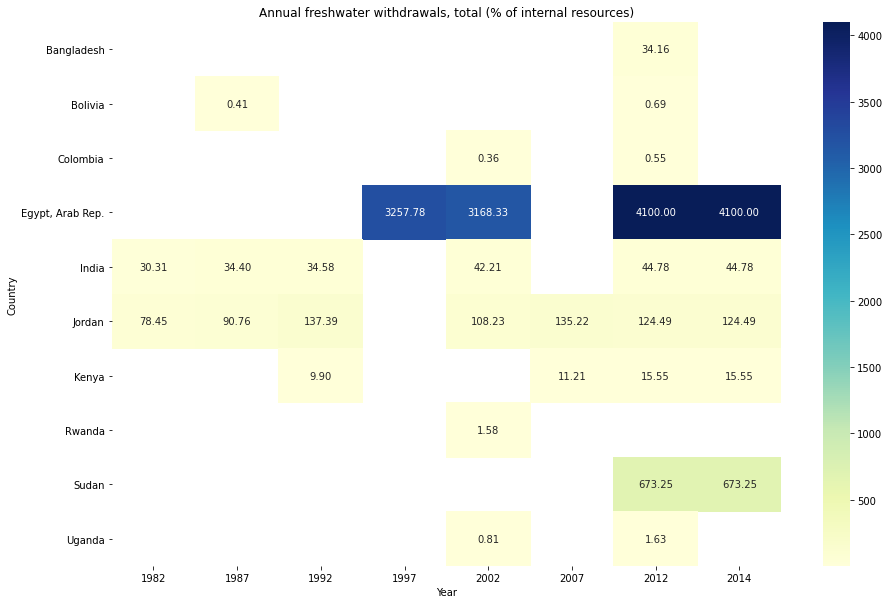

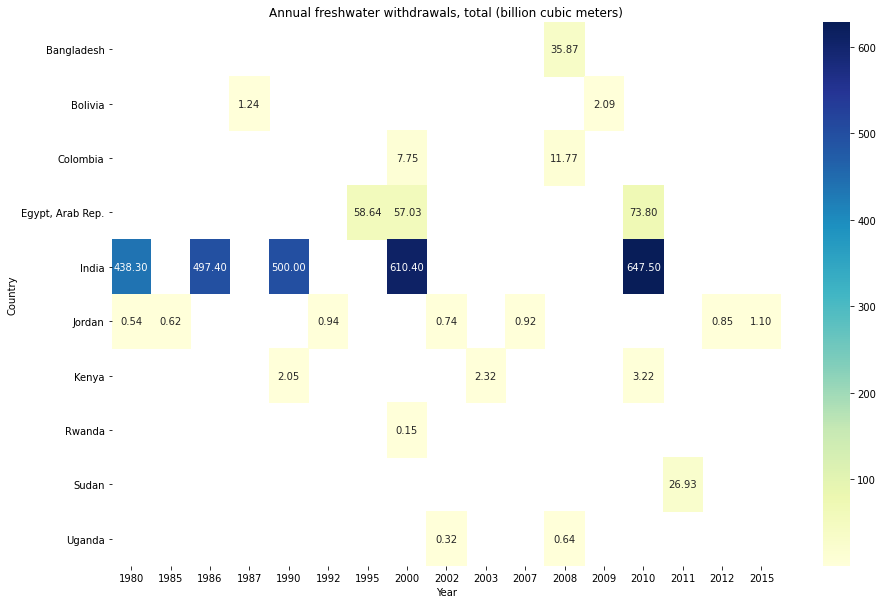

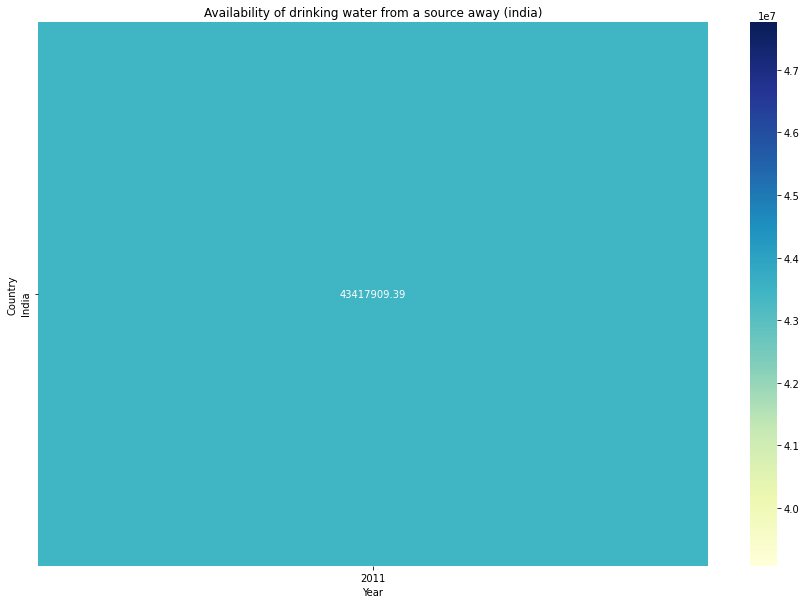

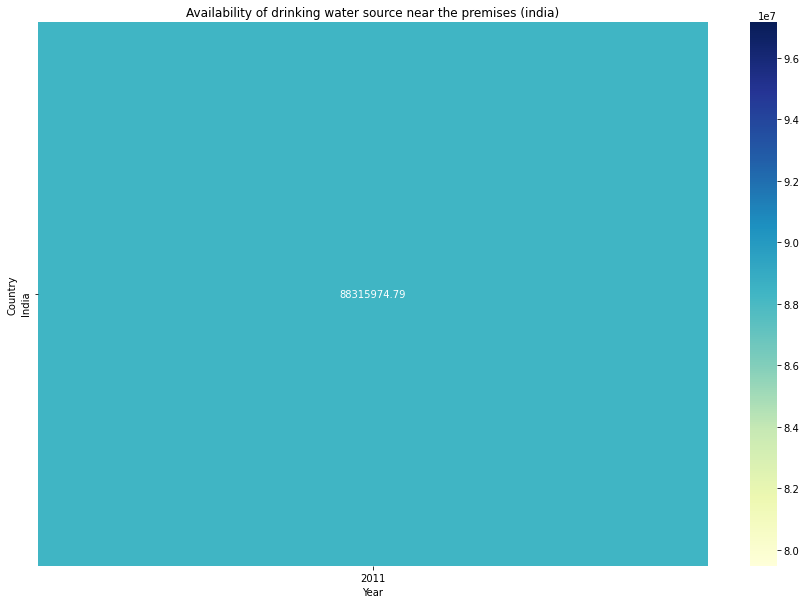

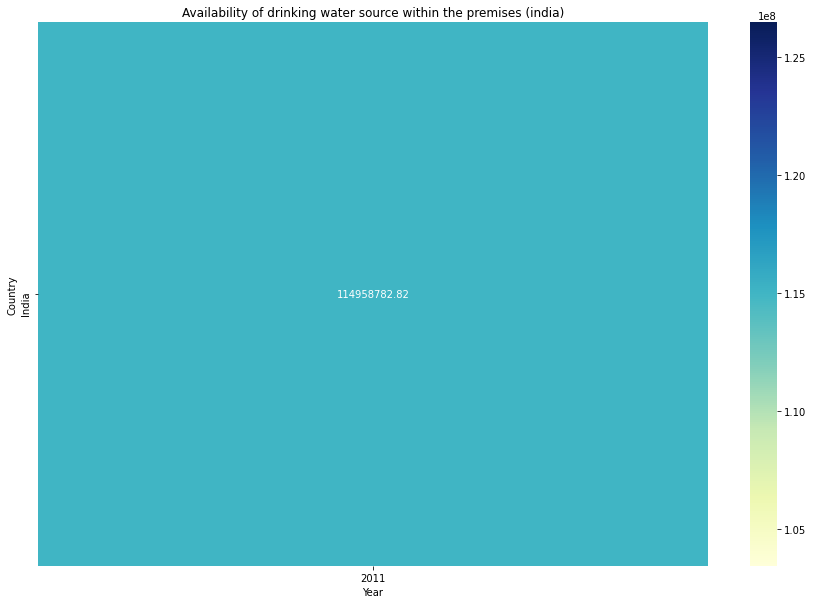

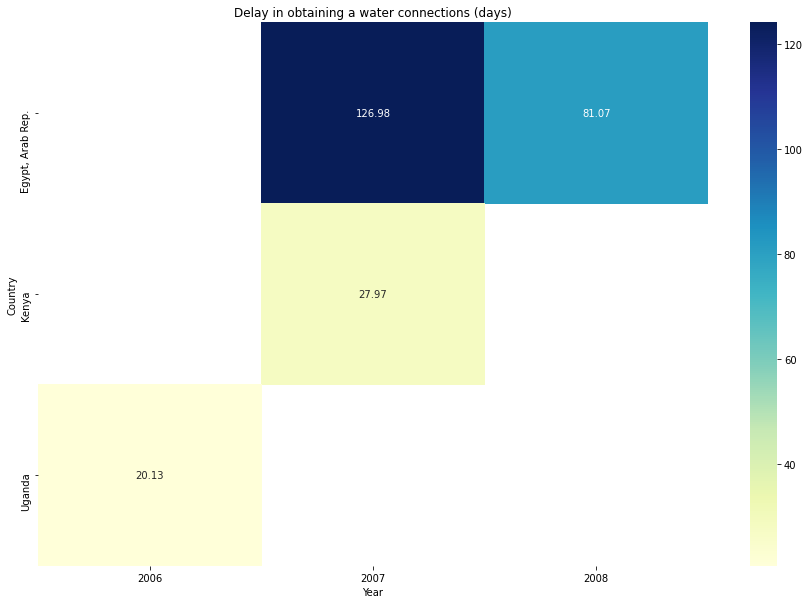

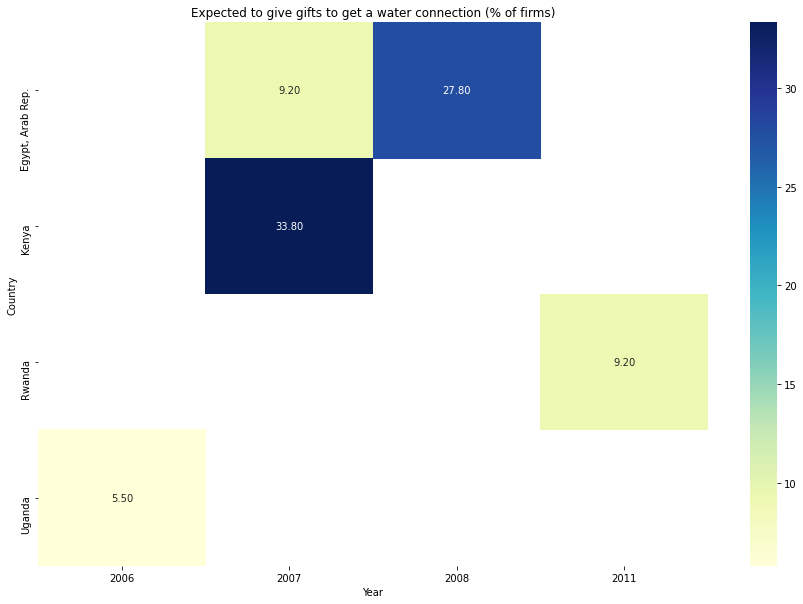

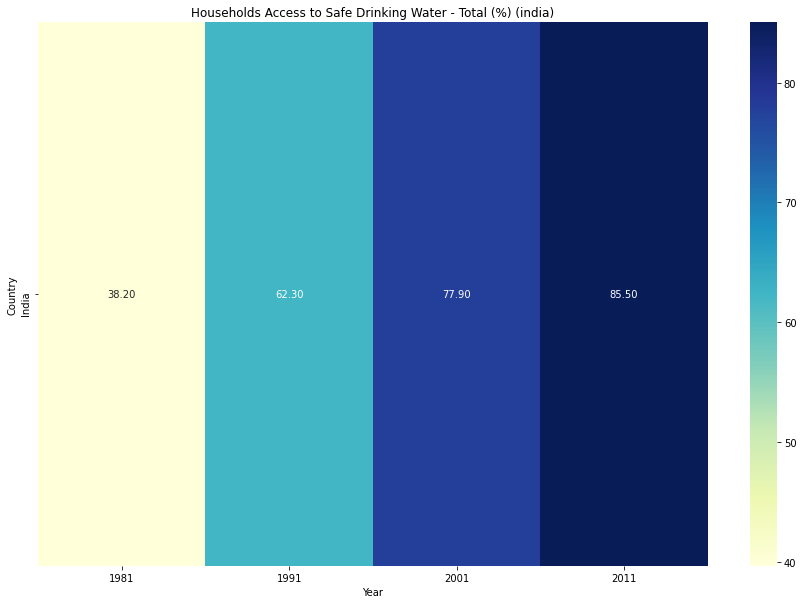

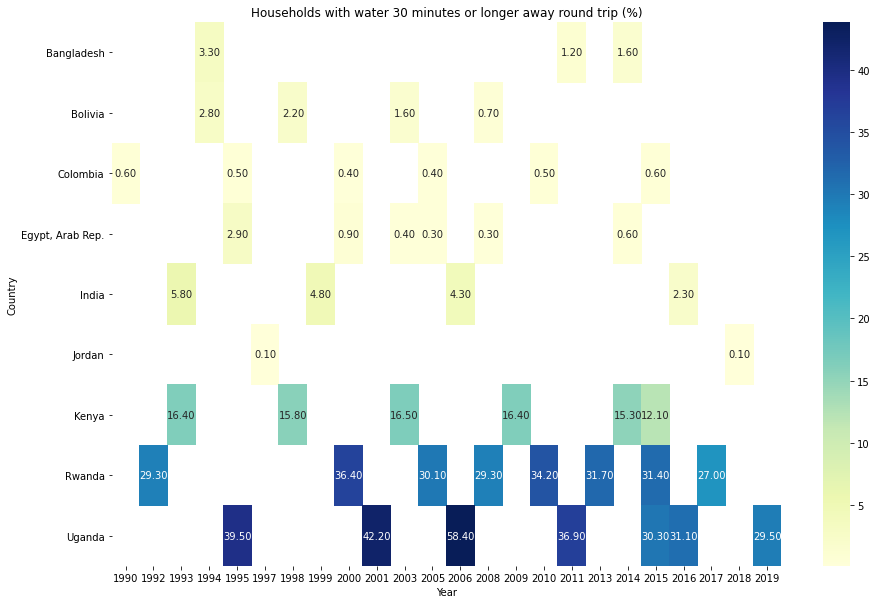

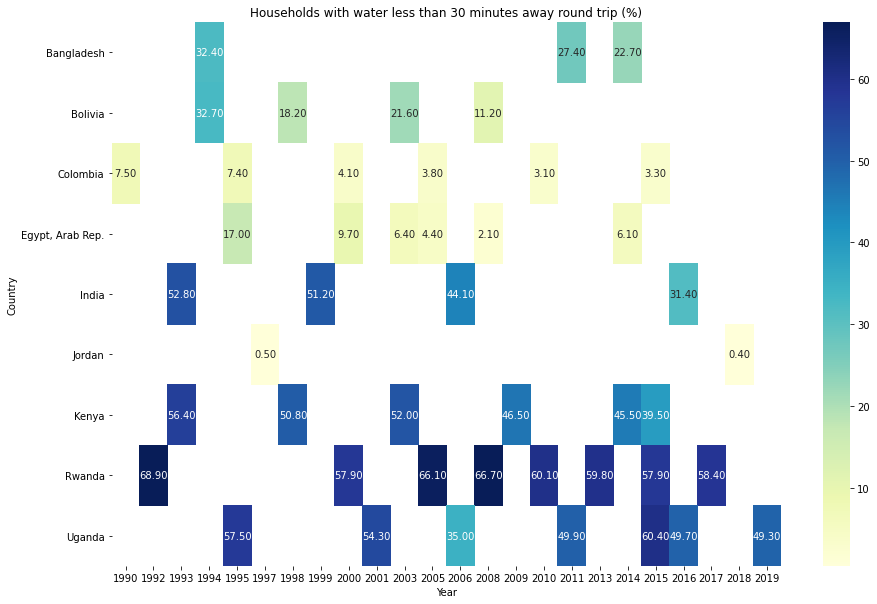

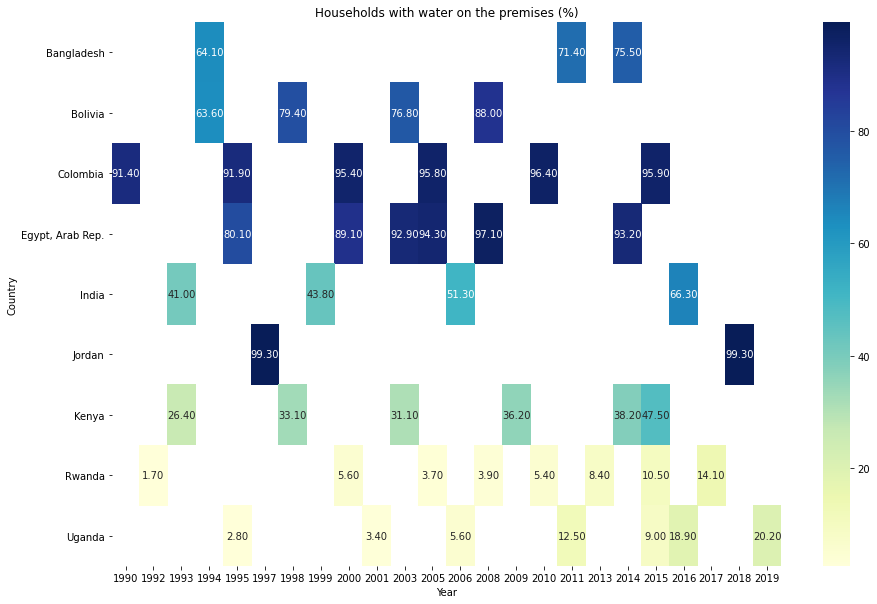

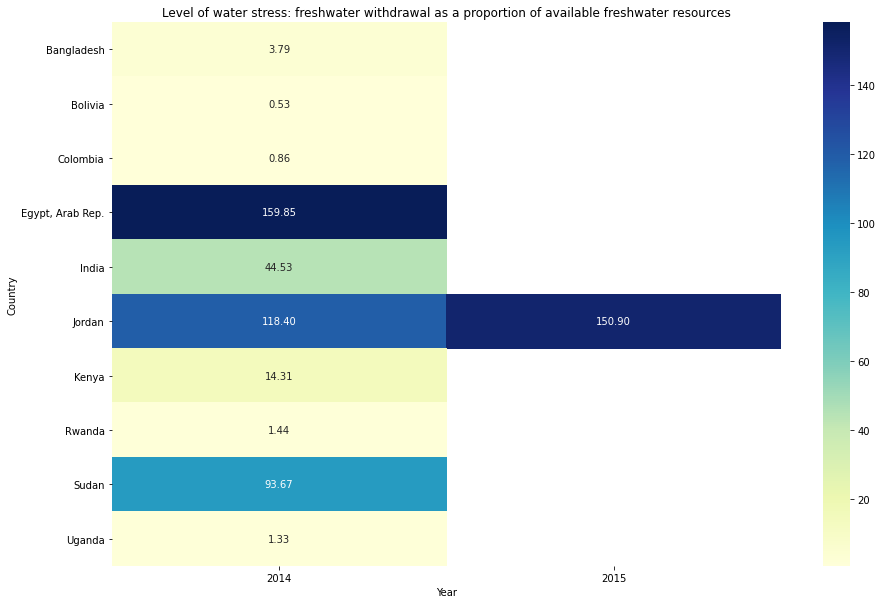

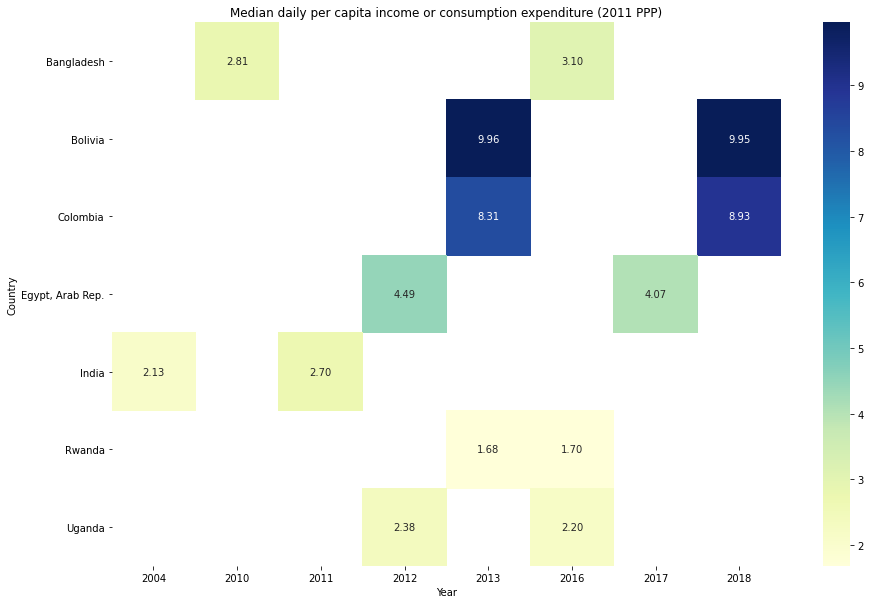

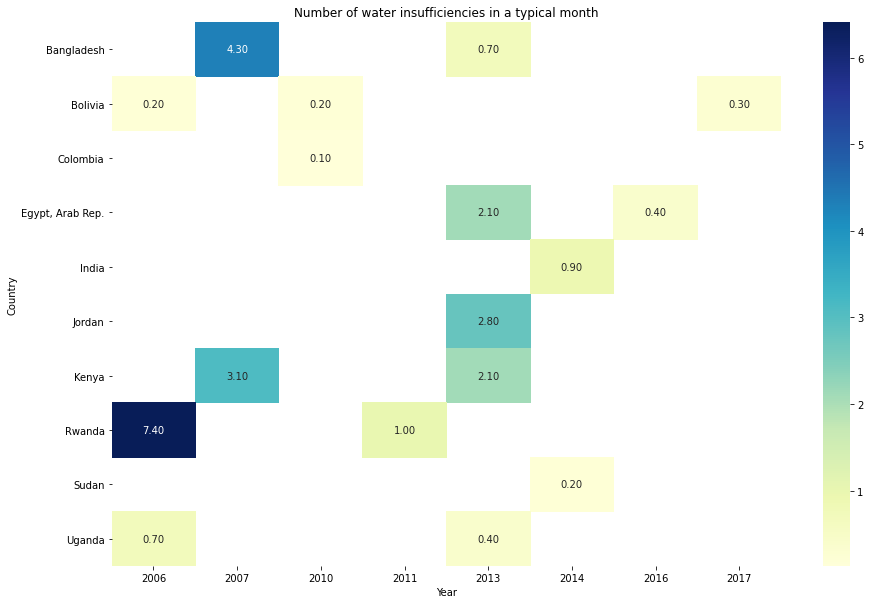

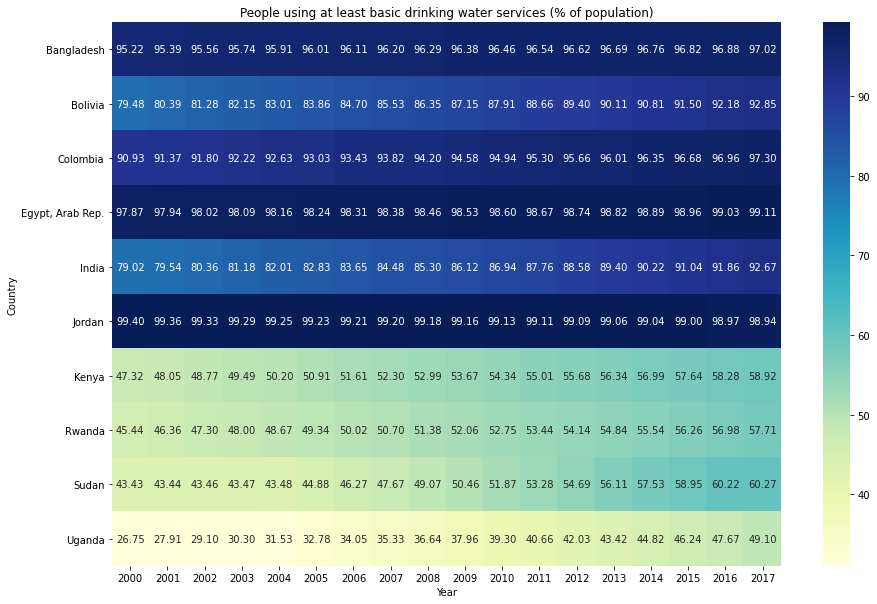

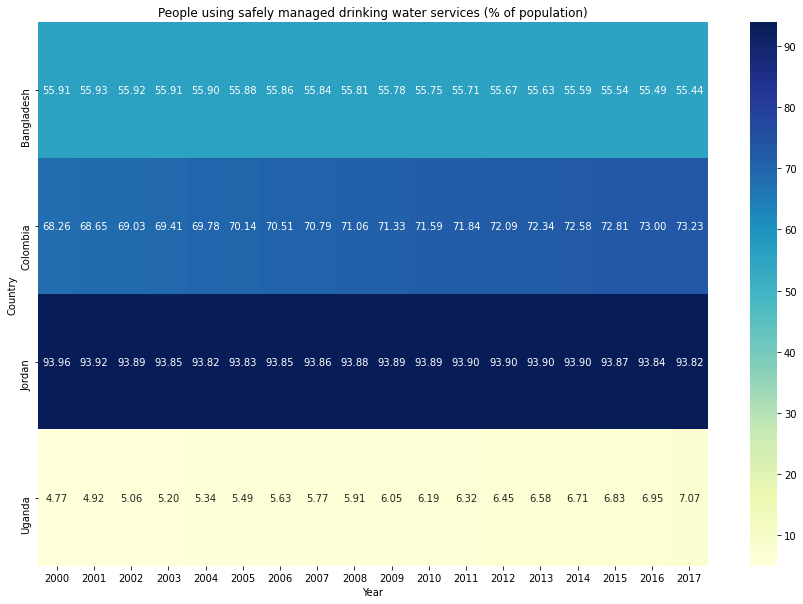

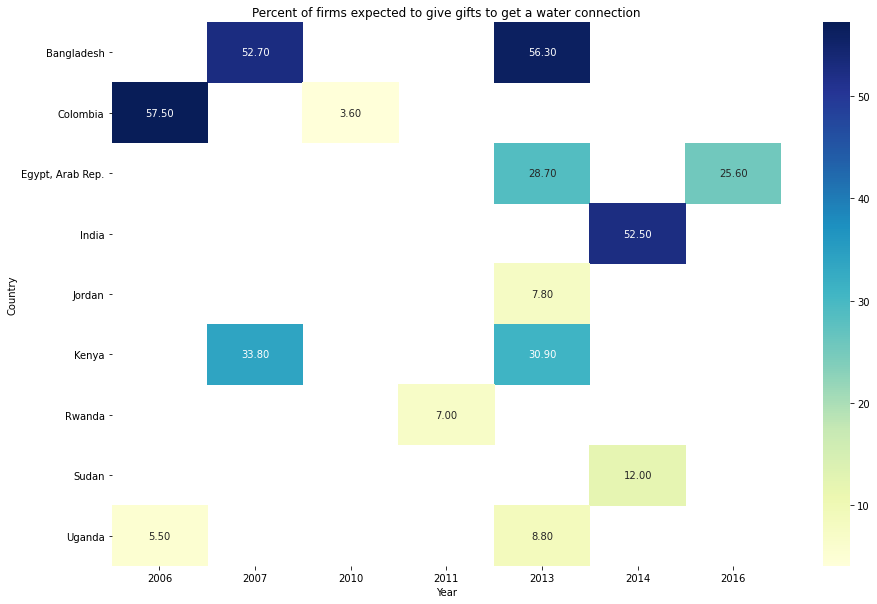

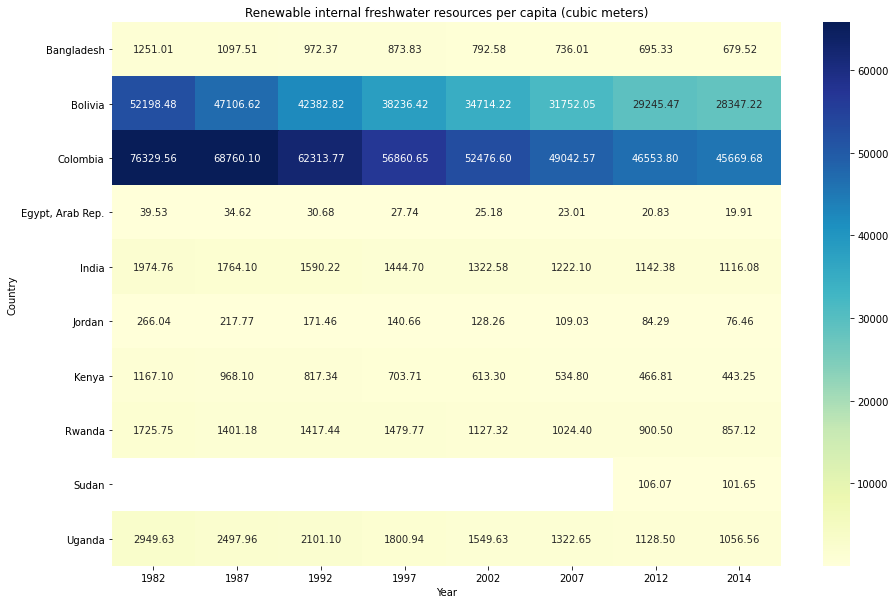

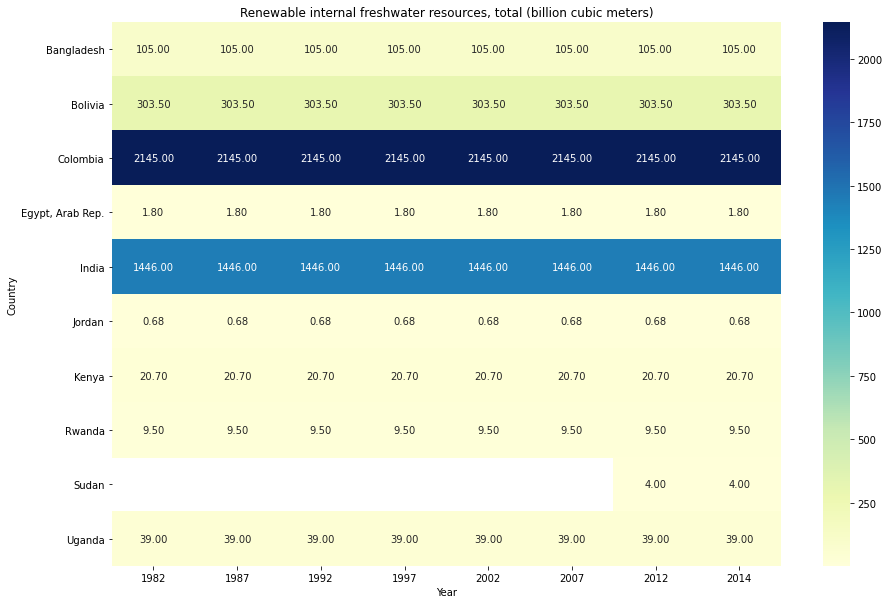

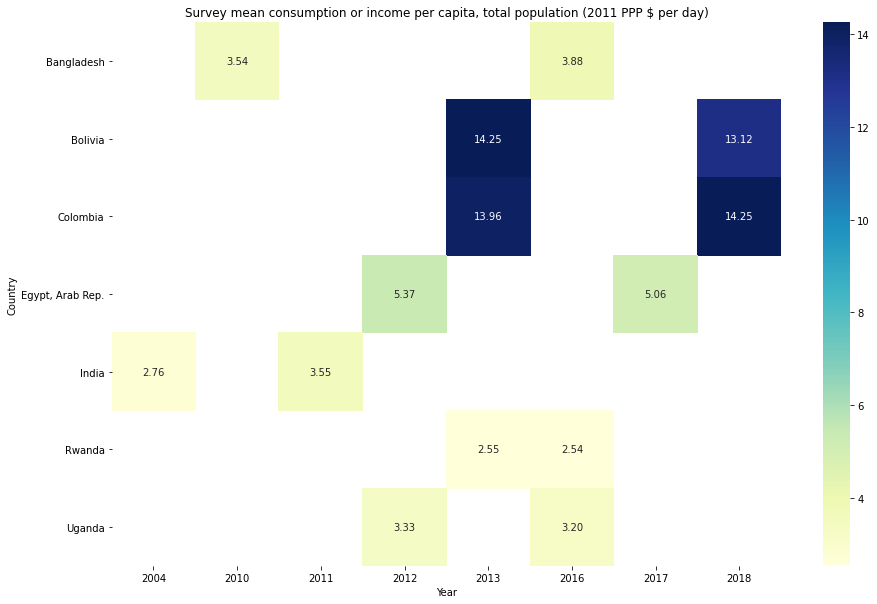

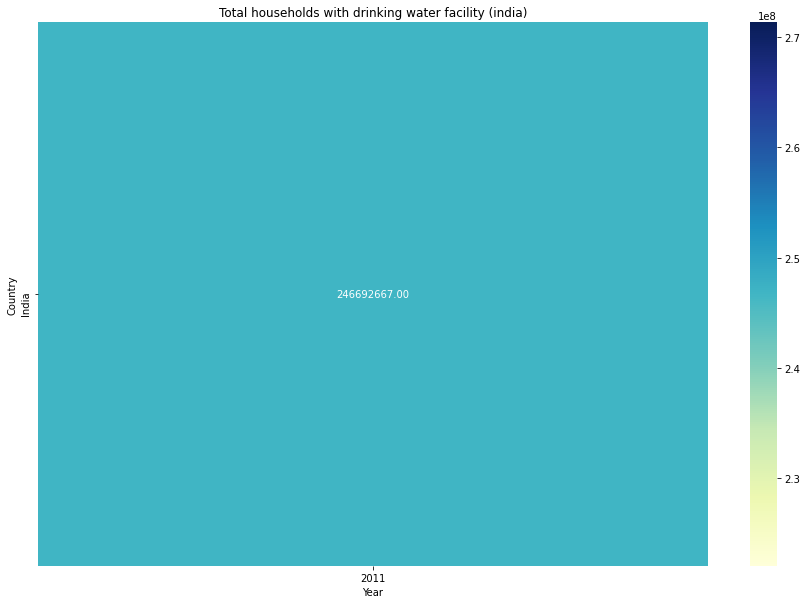

In [8]:
%matplotlib inline
show_text_data = False


for f in ['Annual freshwater withdrawals, total (% of internal resources)',
          'Annual freshwater withdrawals, total (billion cubic meters)',
          'Availability of drinking water from a source away (india)',
          'Availability of drinking water source near the premises (india)',
          'Availability of drinking water source within the premises (india)',
          'Delay in obtaining a water connections (days)',
          'Expected to give gifts to get a water connection (% of firms)',
          'Households Access to Safe Drinking Water - Total (%) (india)',
          'Households with water 30 minutes or longer away round trip (%)',
          'Households with water less than 30 minutes away round trip (%)',
          'Households with water on the premises (%)',
          'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources',
          'Median daily per capita income or consumption expenditure (2011 PPP)',
          'Number of water insufficiencies in a typical month',
          'People using at least basic drinking water services (% of population)',
          'People using safely managed drinking water services (% of population)',
          'Percent of firms expected to give gifts to get a water connection',
          'Renewable internal freshwater resources per capita (cubic meters)',
          'Renewable internal freshwater resources, total (billion cubic meters)',
          'Survey mean consumption or income per capita, total population (2011 PPP $ per day)',
          'Total households with drinking water facility (india)'

     ]:
    #fig, ax = plt.subplots(figsize=(17,8)) 
    try:
        tmp = df[df['Country'].isin(list(itcc))].copy()
        tmp = tmp.replace(countrynames)
        tmp = tmp[['Year','Country',f]].copy()

        tmp = tmp[~tmp[f].isnull()]
        if tmp[f].count() > 0:
            display(HTML("<h3>%s</h3>"% (f)))
            if show_text_data:
                display(tmp)
            tmp2 = tmp.pivot(index='Country', columns='Year', values=f)

            fig, ax = plt.subplots(figsize=(15,10)) 
            ax.set_title("%s" %(f))

            sns.heatmap(tmp2, annot=True,ax=ax,fmt=".2f",cmap="YlGnBu",robust=True)

            #tmp.plot(ax=ax,grid=True,kind="bar",figsize=(12,5), title = ).legend(loc='lower right',bbox_to_anchor=(1.0, 0.5));

            plt.show()
    except Exception as e:
        print(e)
        pass
    finally:
        if fig:
            plt.close(fig)


In [9]:
%matplotlib inline

split_per_country = False

if split_per_country:

    for c in tcc:
        display(HTML("<h2>%s</h2>" %(c)))
        for f in ['Annual freshwater withdrawals, total (% of internal resources)',
                  'Annual freshwater withdrawals, total (billion cubic meters)',
                  'Availability of drinking water from a source away (india)',
                  'Availability of drinking water source near the premises (india)',
                  'Availability of drinking water source within the premises (india)',
                  'Delay in obtaining a water connections (days)',
                  'Expected to give gifts to get a water connection (% of firms)',
                  'Households Access to Safe Drinking Water - Total (%) (india)',
                  'Households with water 30 minutes or longer away round trip (%)',
                  'Households with water less than 30 minutes away round trip (%)',
                  'Households with water on the premises (%)',
                  'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources',
                  'Median daily per capita income or consumption expenditure (2011 PPP)',
                  'Number of water insufficiencies in a typical month',
                  'People using at least basic drinking water services (% of population)',
                  'People using safely managed drinking water services (% of population)',
                  'Percent of firms expected to give gifts to get a water connection',
                  'Renewable internal freshwater resources per capita (cubic meters)',
                  'Renewable internal freshwater resources, total (billion cubic meters)',
                  'Survey mean consumption or income per capita, total population (2011 PPP $ per day)',
                  'Total households with drinking water facility (india)'

             ]:

            fig, ax = plt.subplots(figsize=(17,8)) 
            try:
                tmp = df[df['Country'] == c].copy()
                tmp = tmp[['Year',f]].copy()

                tmp = tmp[~tmp[f].isnull()]
                tmp = tmp.set_index('Year')
                if tmp[f].count() > 0:
                    display(HTML("<h3>%s</h3>"% (f)))
                    tmp.plot(ax=ax,grid=True,kind="bar",figsize=(12,5), title = "%s: %s" %(c,f)).legend(loc='lower right',bbox_to_anchor=(1.0, 0.5));

                    plt.show()
            except Exception as e:
                print(e)
                pass
            finally:
                plt.close(fig)


In [10]:
idf = merge_wbseries_with_oecd_data(oecddf,df,codemapping=codemapping,cachedir=cachedir,mergedonor=False)

Reading Data from cached file: ../data/cache/countrycodes.p


In [11]:
idf.sample(5).T

,51233,37473,54007,213943,60006
DonorName,International Bank for Reconstruction and Development,Germany,Canada,Korea,Japan
RecipientName,Egypt,Jordan,Kenya,Sudan,Jordan
DonorCode,901,5,301,742,701
RecipientCode,142,549,248,278,549
IncomegroupName,LMICs,LMICs,LMICs,LDCs,LMICs
USD_Commitment_Defl,NaN,NaN,NaN,0.0200932,NaN
USD_Received_Defl,0.0053178,0.152819,NaN,NaN,NaN
ShortDescription,EGYPT POLLUTION ABATEMENT PROJECT,COMMODITY AID V,GENDER EQUITY SUPPORT PROJECT,ADVANCED TECH. & MANAGERIAL TRAINING,TO IMPROVE THE QUALITY OF EDUCATION
AgencyName,IBRD,Bundesministerium für Wirtschaftliche Zusammenarbeit und Entwicklung,Canadian International Development Agency,Miscellaneous,OECF
FlowCode,14,13,11,11,13


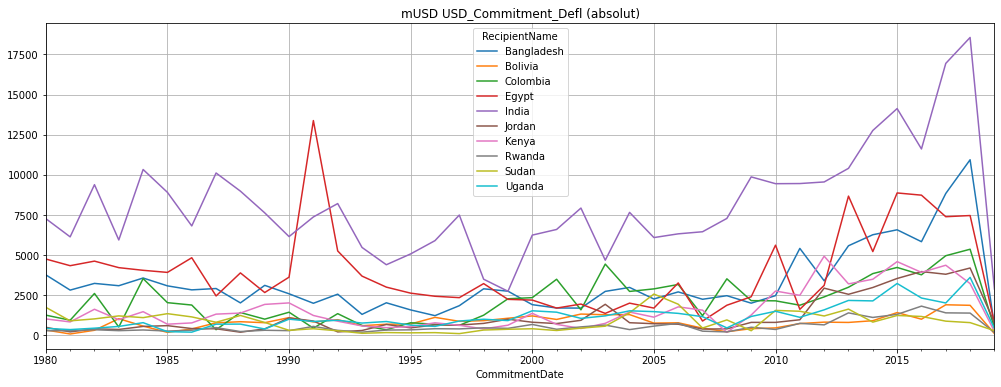

In [12]:
display(HTML("<h3>all projects for selected countries</h3>"))
tmp = idf.set_index("CommitmentDate")
tmp2 = tmp.groupby([Grouper(freq="A"), 'RecipientName'])['USD_Commitment_Defl'].sum().unstack()
ax = tmp2.plot(grid=True,kind='line', figsize=(17,6),title="mUSD USD_Commitment_Defl (absolut)")
plt.show()

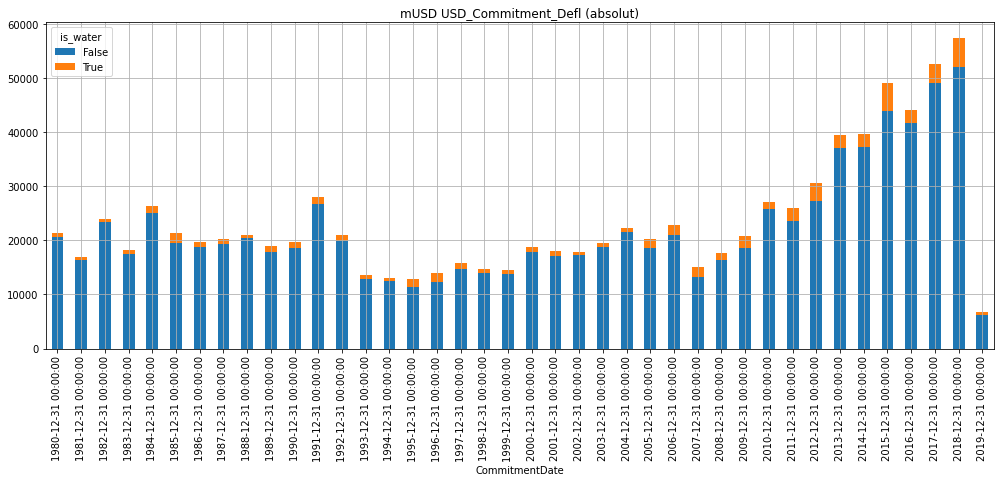

In [13]:
display(HTML("<h3>water projects for selected countries</h3>"))
tmp = idf.set_index("CommitmentDate")
tmp['is_water'] = tmp['SectorCode'].apply(lambda x: x == "140")
tmp2 = tmp.groupby([Grouper(freq="A"), 'is_water'])['USD_Commitment_Defl'].sum().unstack()
ax = tmp2.plot(grid=True,kind='bar', stacked=True,figsize=(17,6),title="mUSD USD_Commitment_Defl (absolut)")
plt.show()

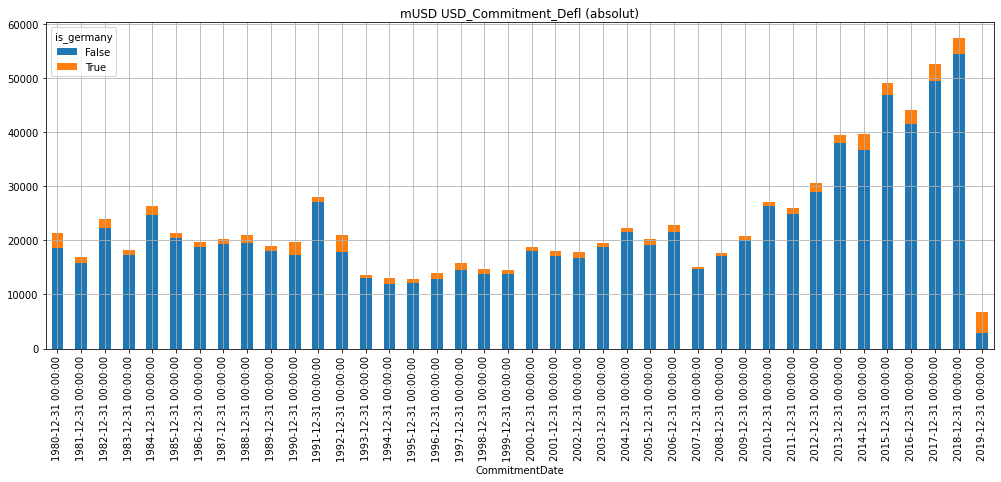

In [14]:
display(HTML("<h3>german projects for selected countries</h3>"))
tmp = idf.set_index("CommitmentDate")
tmp['is_germany'] = tmp['DonorCode'].apply(lambda x: x == "5")
tmp2 = tmp.groupby([Grouper(freq="A"), 'is_germany'])['USD_Commitment_Defl'].sum().unstack()
ax = tmp2.plot(grid=True,kind='bar', stacked=True,figsize=(17,6),title="mUSD USD_Commitment_Defl (absolut)")
plt.show()

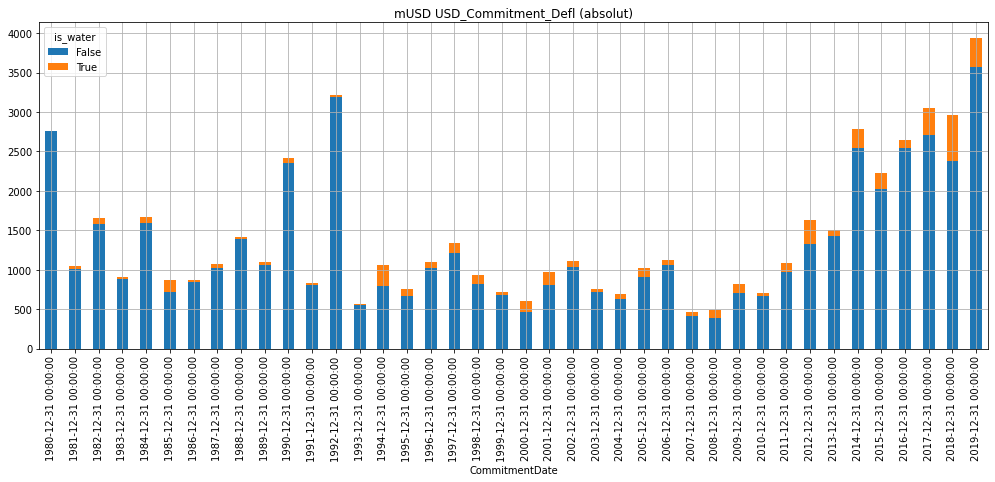

In [15]:
display(HTML("<h3>german water projects for selected countries</h3>"))
tmp = idf.set_index("CommitmentDate")
tmp = tmp[tmp["DonorCode"] == "5"]
tmp['is_water'] = tmp['SectorCode'].apply(lambda x: x == "140")
tmp2 = tmp.groupby([Grouper(freq="A"), 'is_water'])['USD_Commitment_Defl'].sum().unstack()
ax = tmp2.plot(grid=True,kind='bar', stacked=True,figsize=(17,6),title="mUSD USD_Commitment_Defl (absolut)")
plt.show()

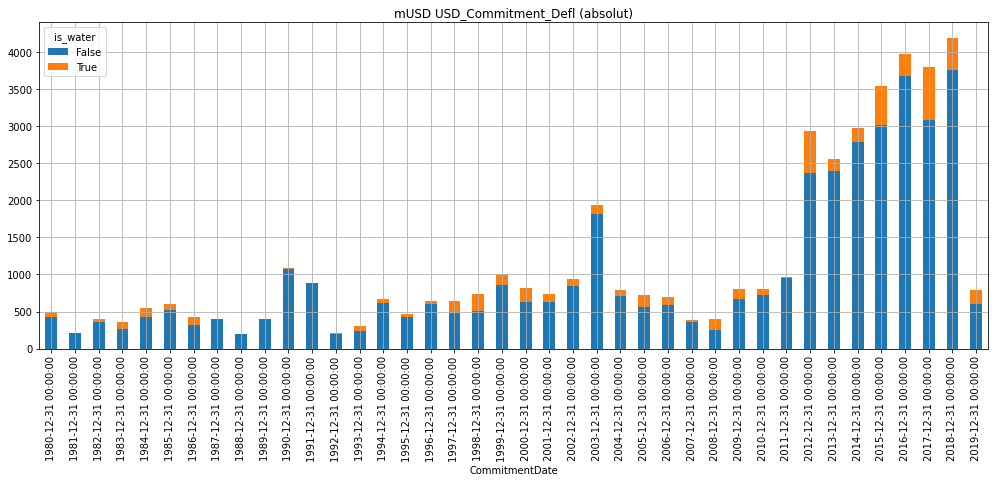

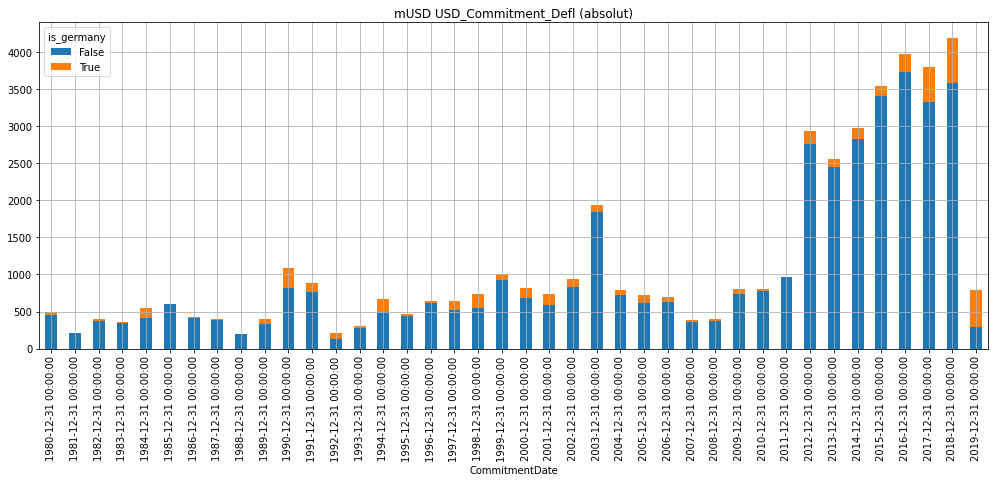

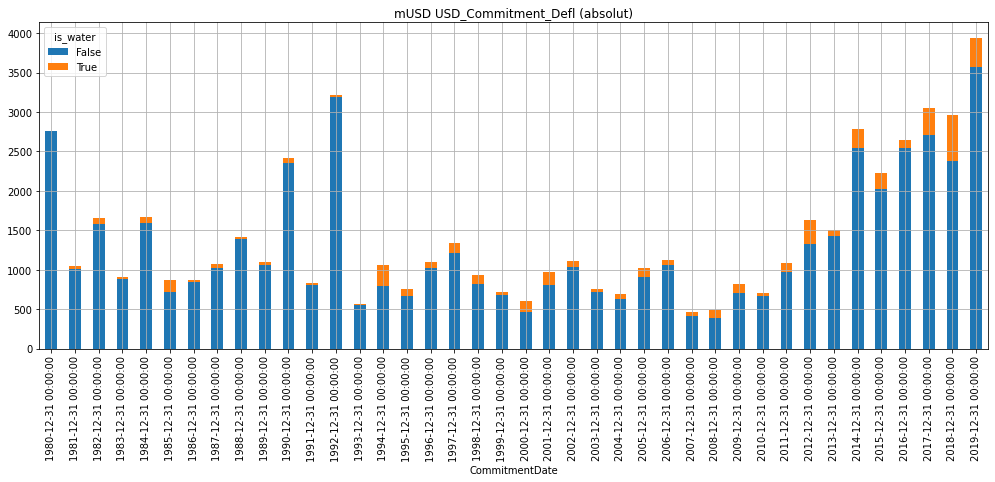

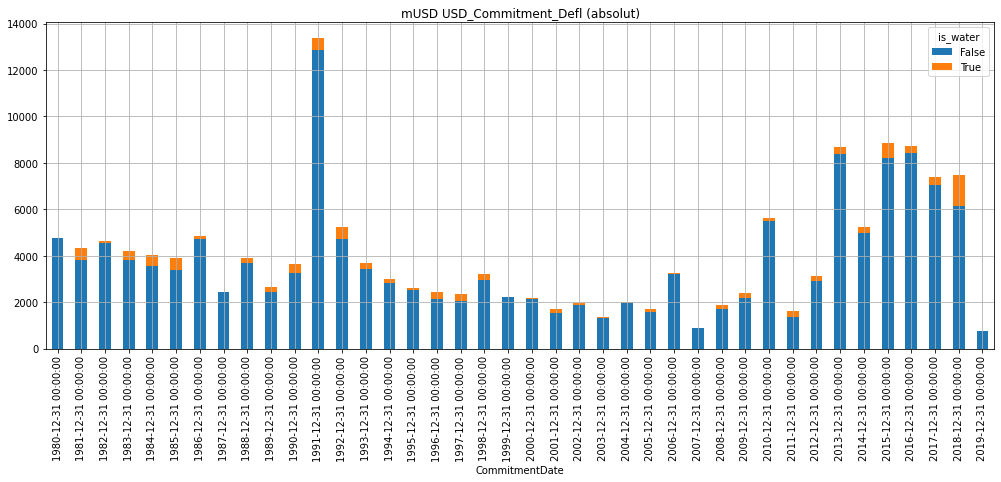

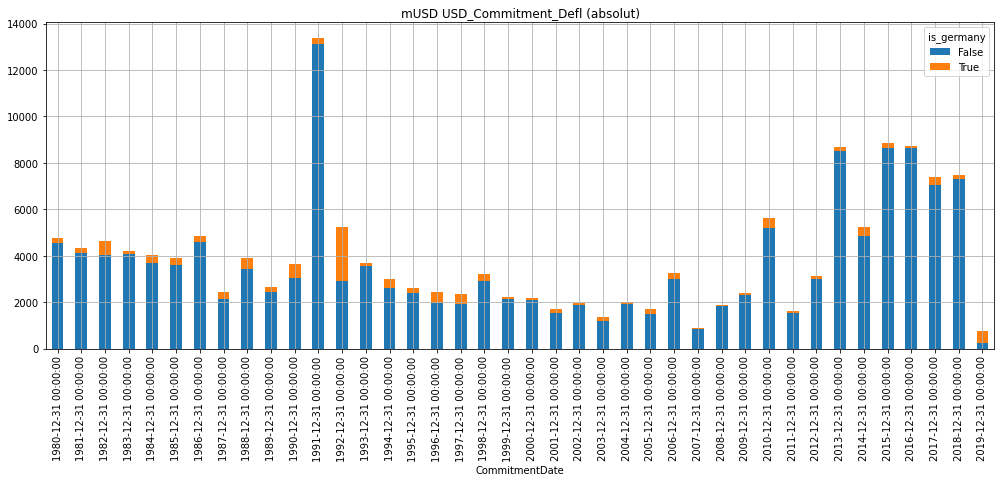

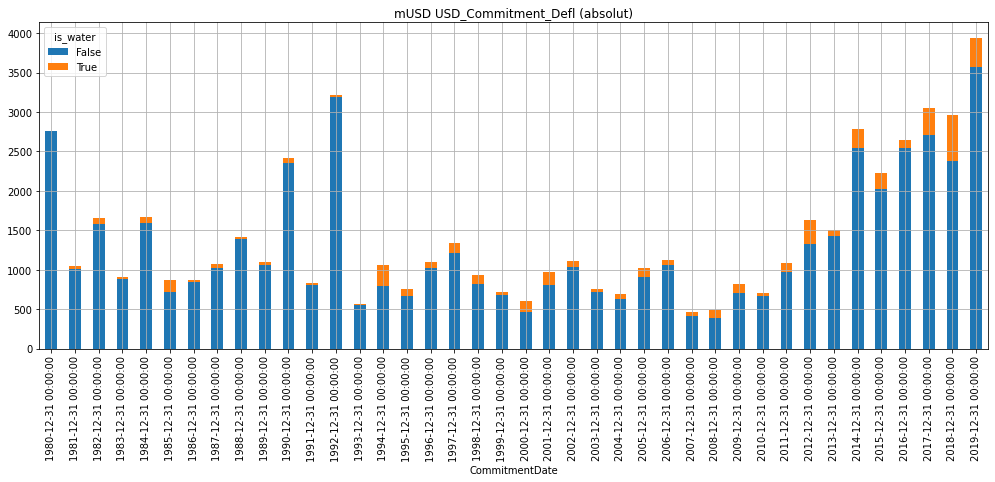

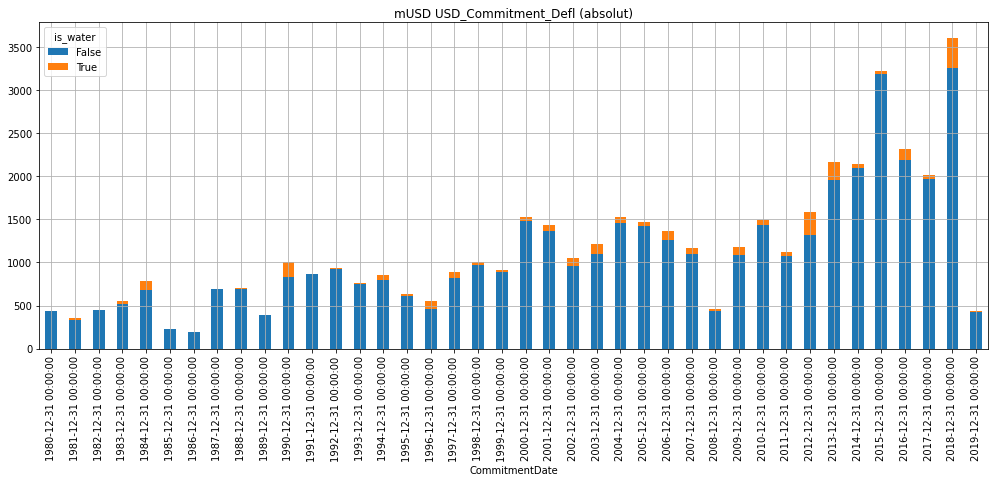

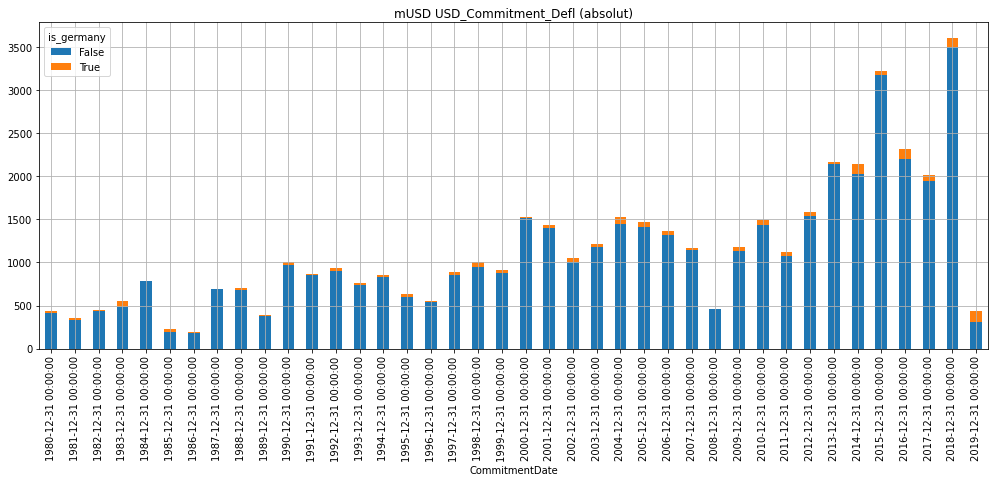

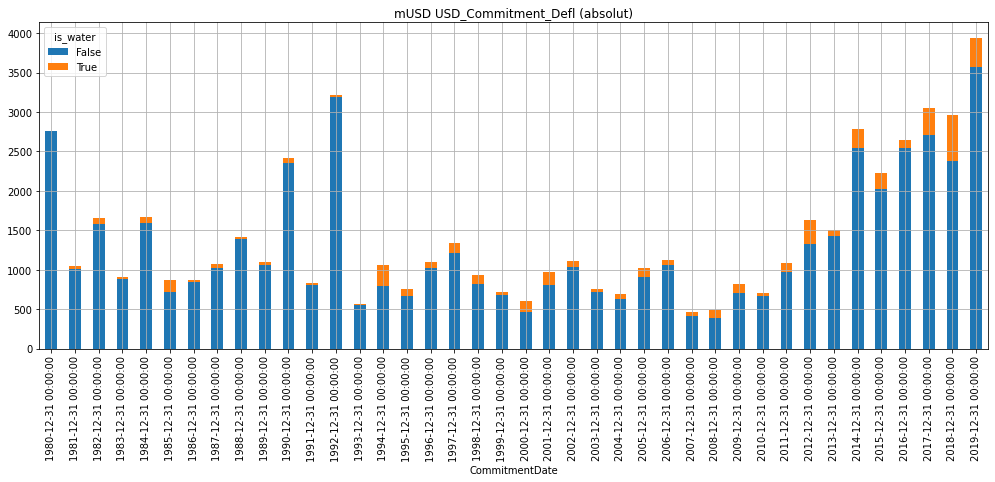

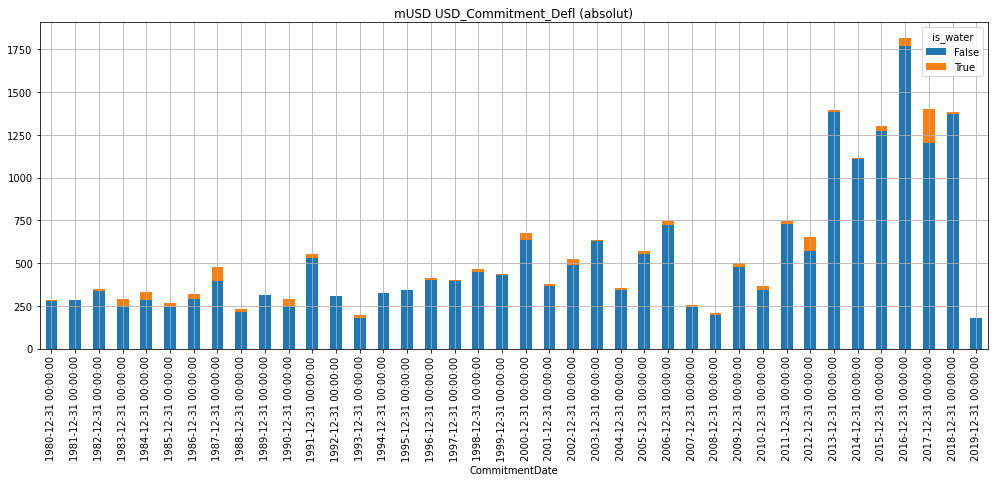

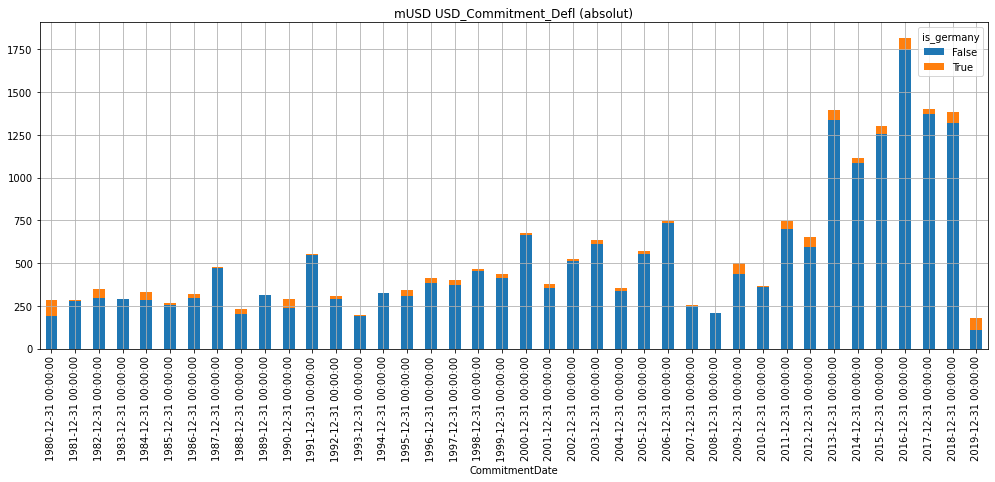

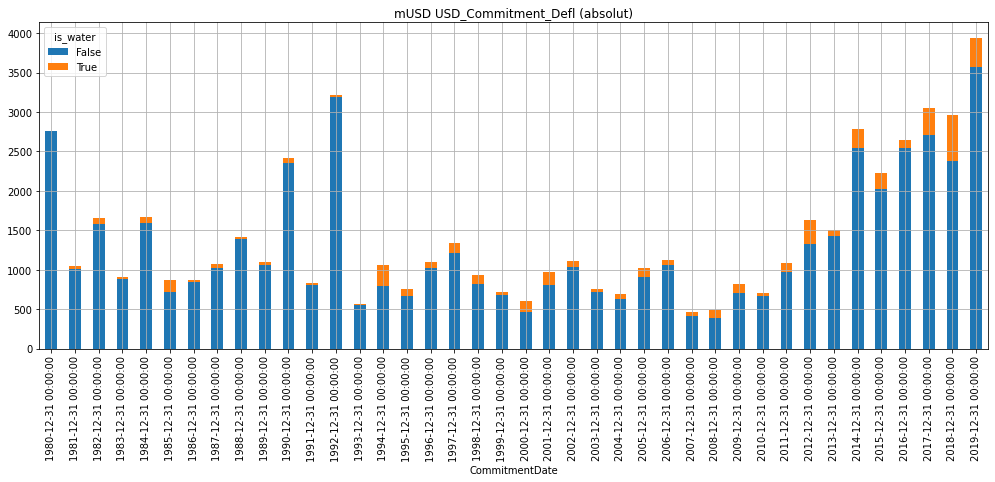

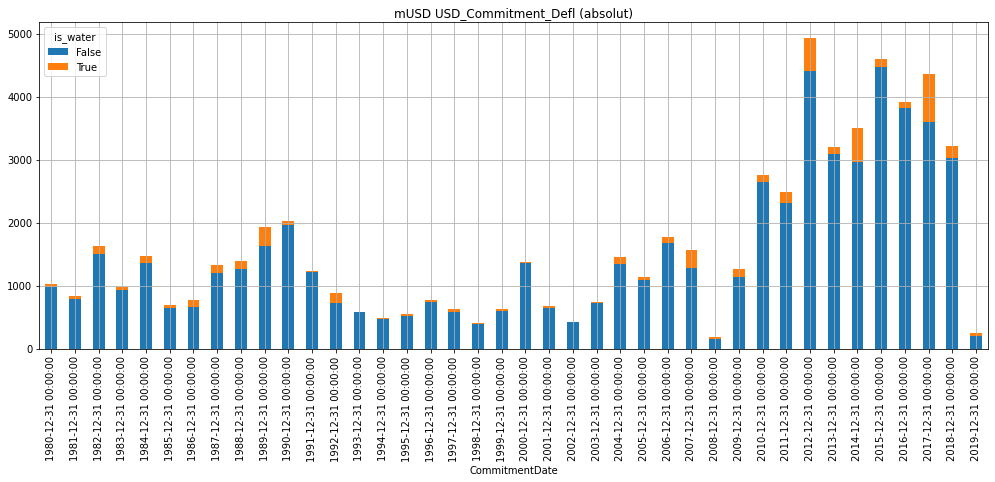

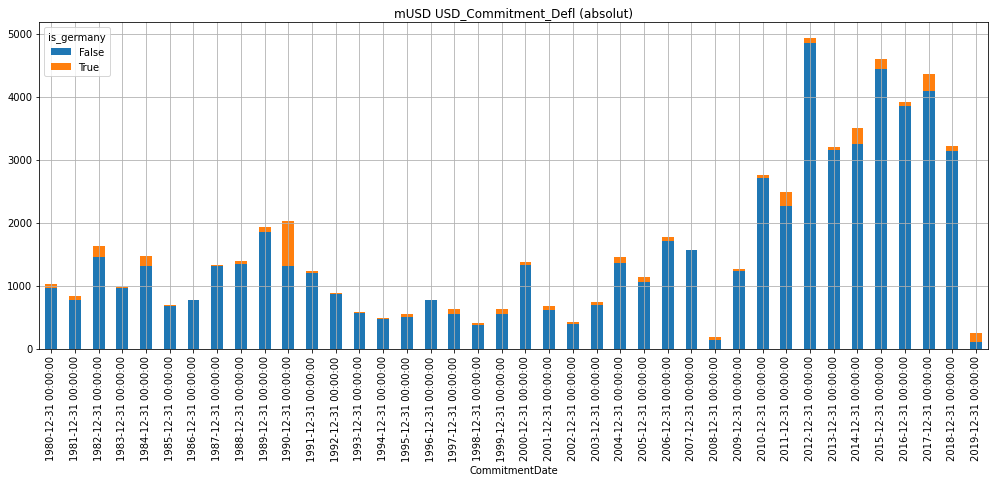

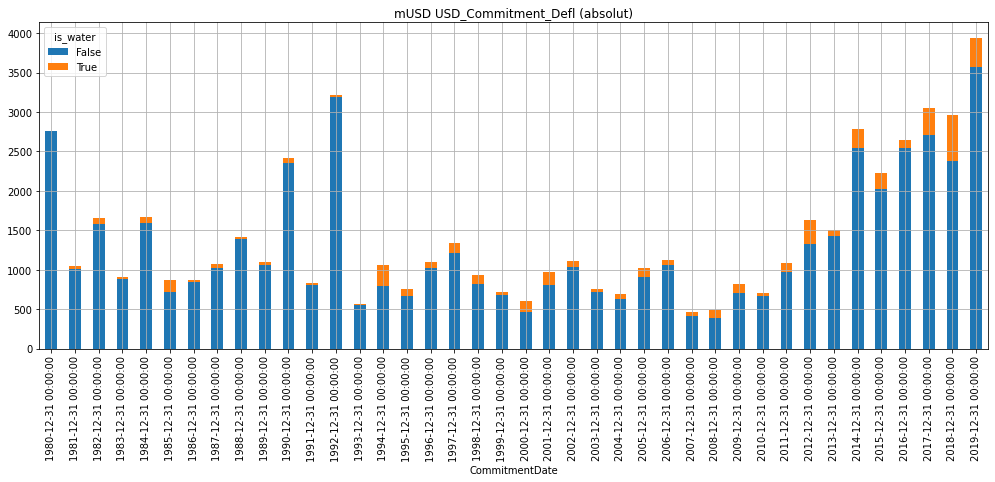

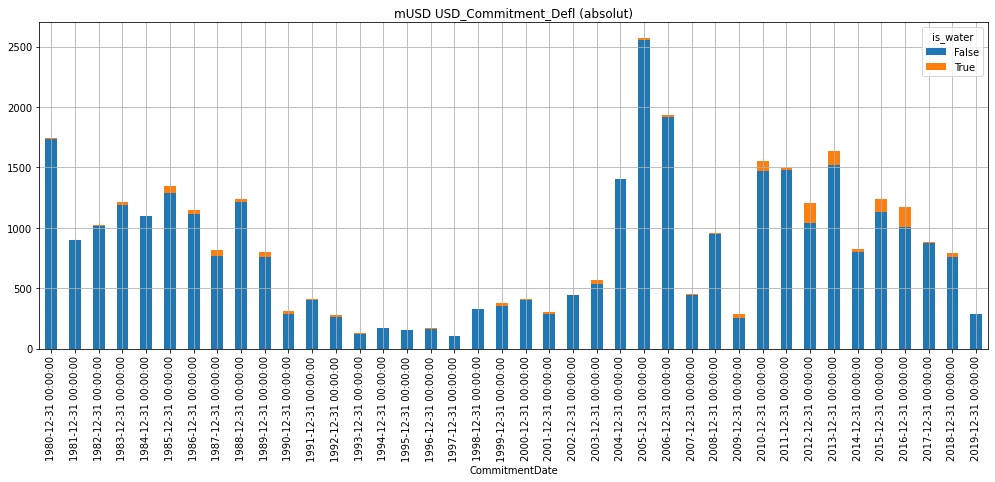

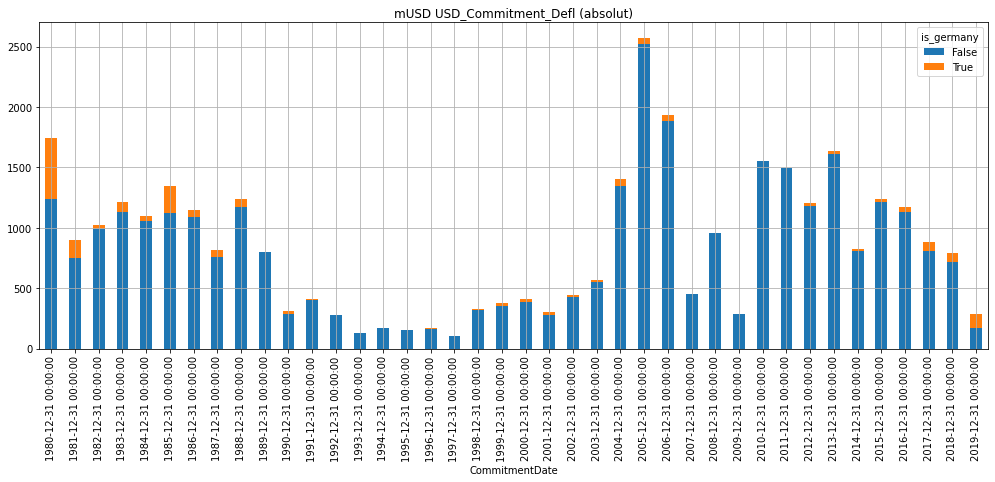

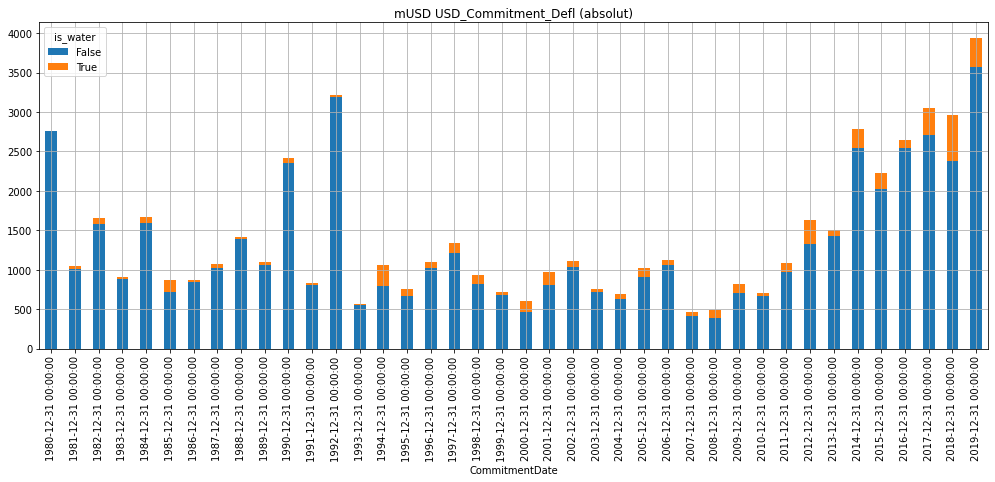

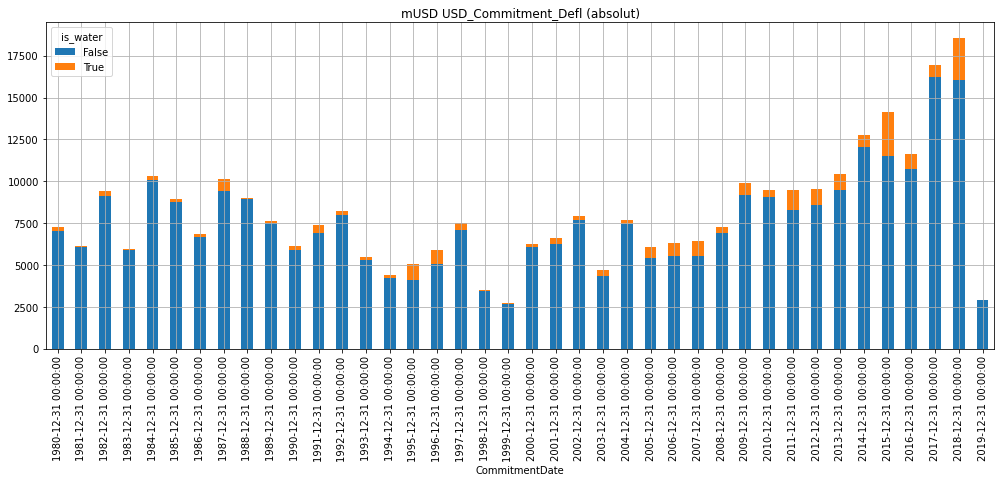

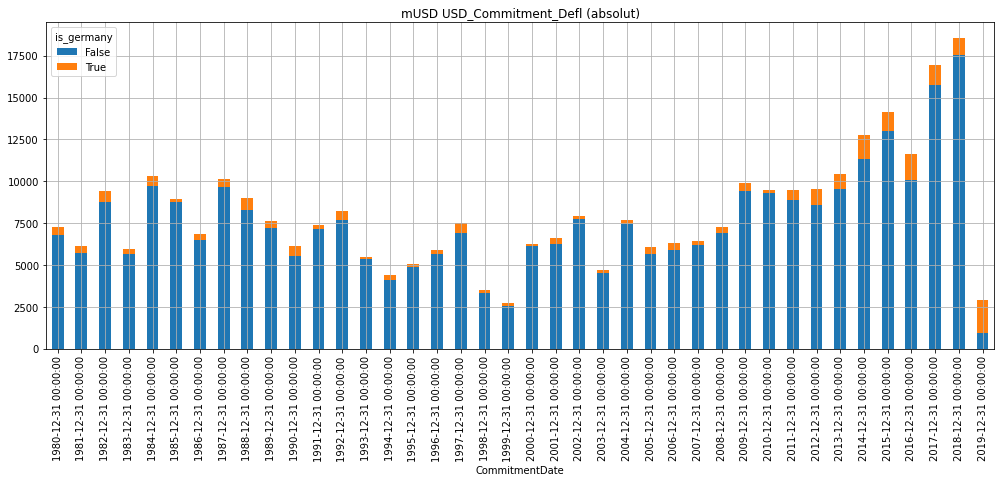

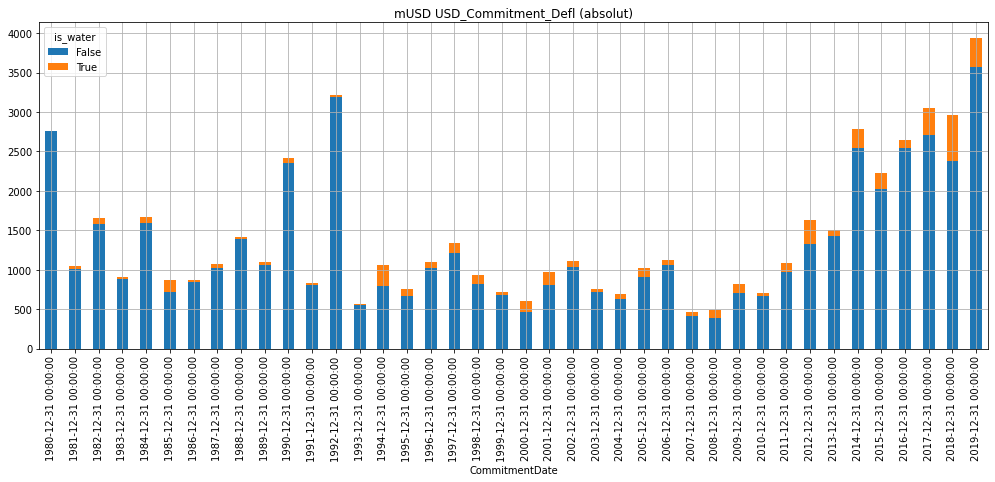

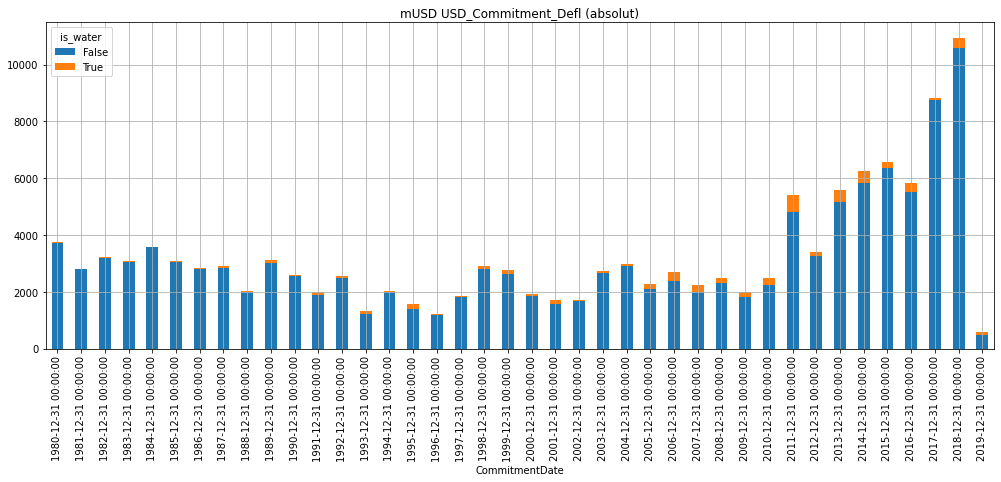

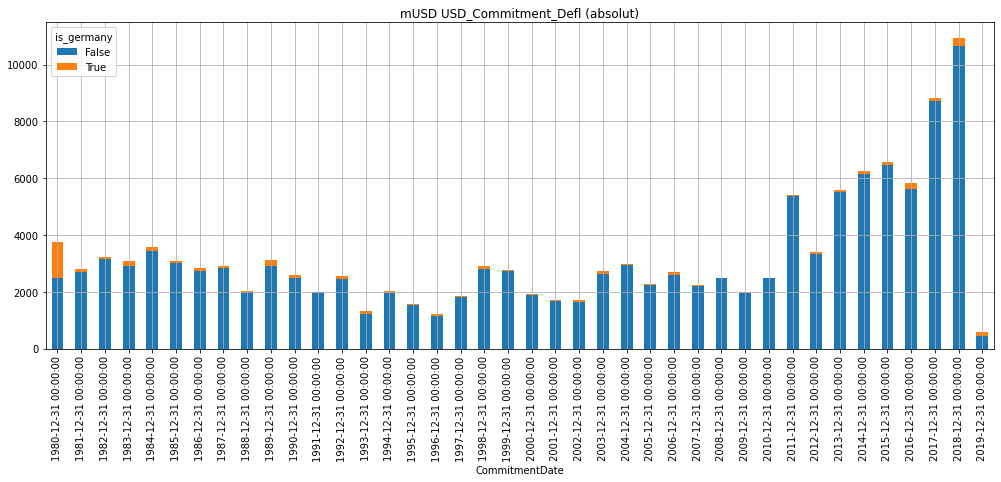

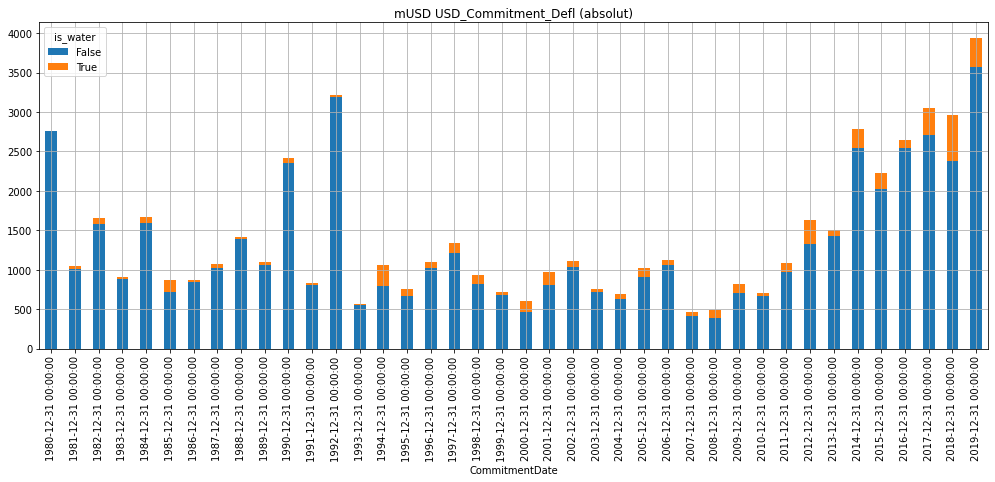

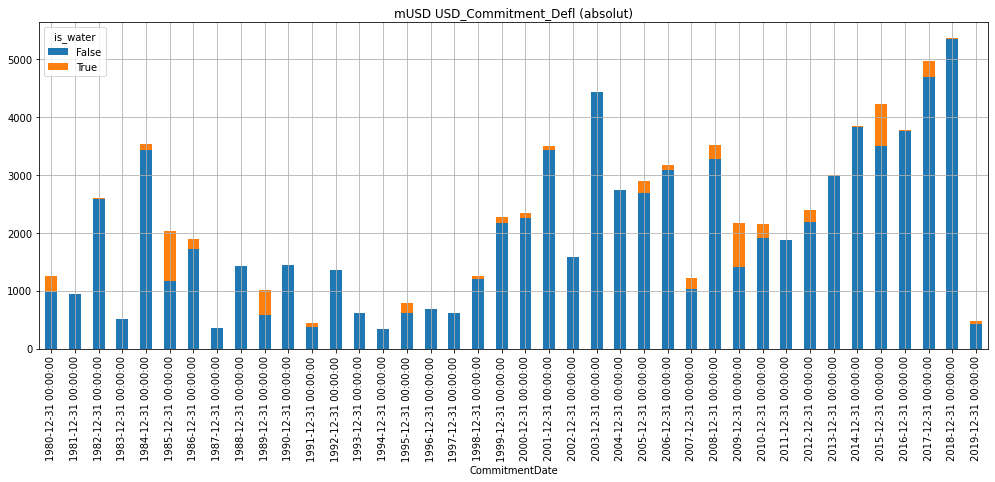

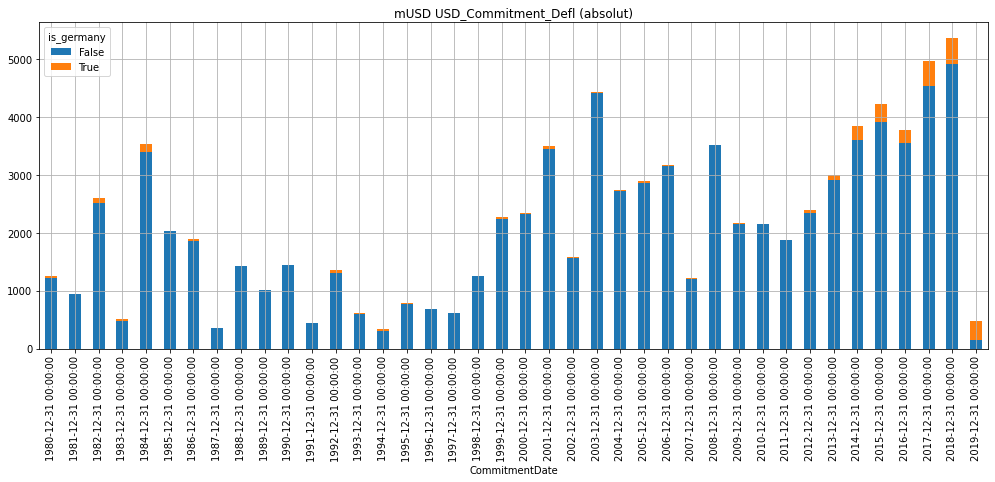

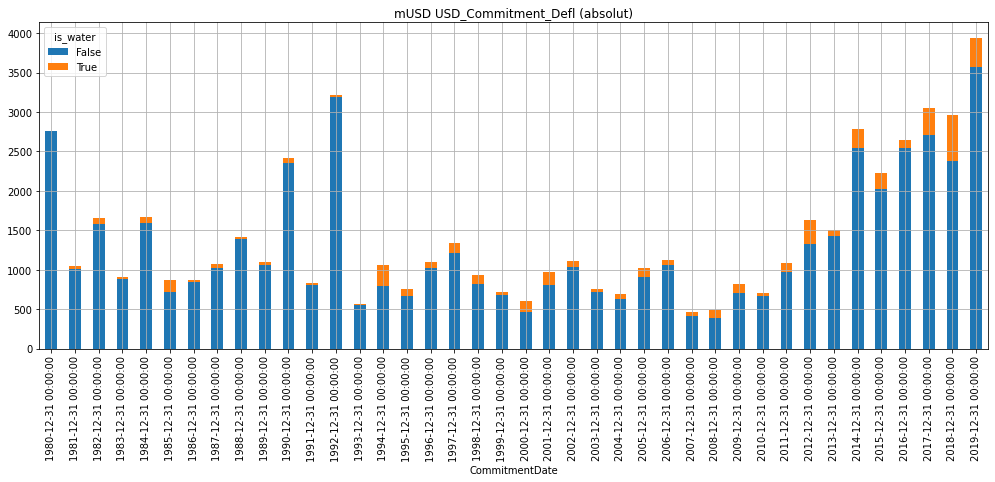

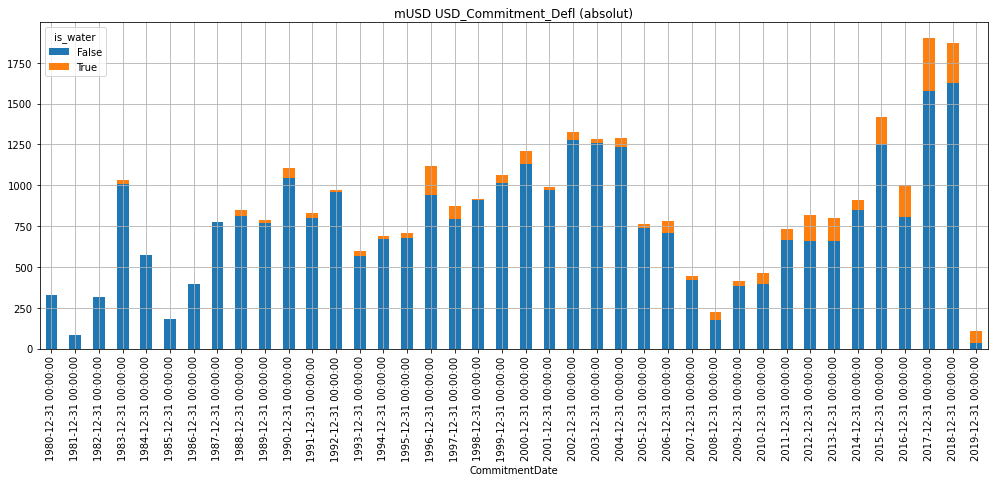

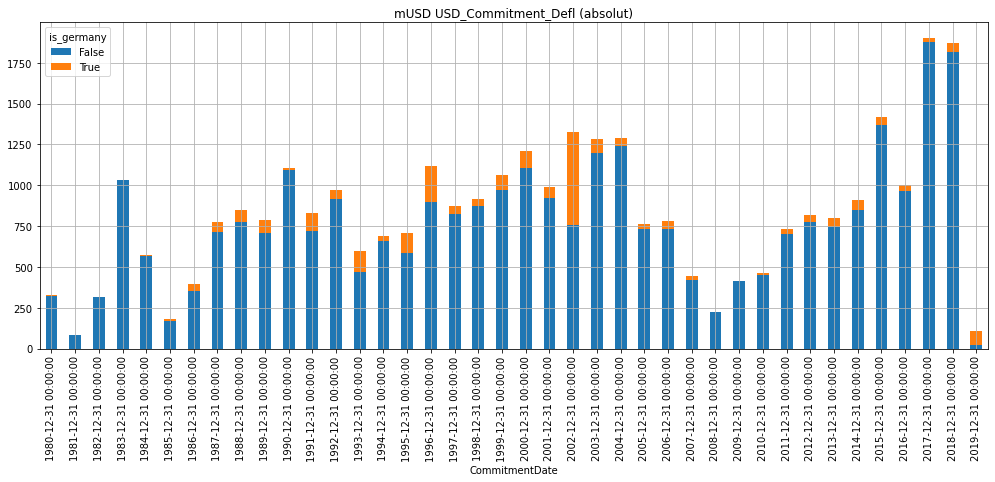

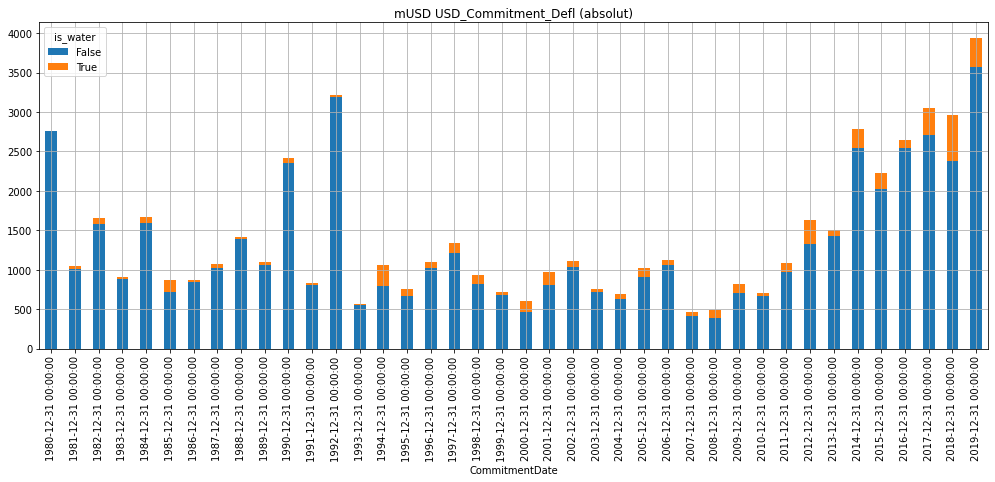

In [16]:
for r in tcc:
    display(HTML("<h3>water projects for %s</h3>" %(r)))
    tmp = idf.set_index("CommitmentDate")
    tmp = tmp[tmp['Recipientstat name'] == r]
    tmp['is_water'] = tmp['SectorCode'].apply(lambda x: x == "140")
    tmp2 = tmp.groupby([Grouper(freq="A"), 'is_water'])['USD_Commitment_Defl'].sum().unstack()
    ax = tmp2.plot(grid=True,kind='bar', stacked=True,figsize=(17,6),title="mUSD USD_Commitment_Defl (absolut)")
    plt.show()
    display(HTML("<h3>german projects for %s</h3>" %(r)))
    tmp = idf.set_index("CommitmentDate")
    tmp = tmp[tmp['Recipientstat name'] == r]
    tmp['is_germany'] = tmp['DonorCode'].apply(lambda x: x == "5")
    tmp2 = tmp.groupby([Grouper(freq="A"), 'is_germany'])['USD_Commitment_Defl'].sum().unstack()
    ax = tmp2.plot(grid=True,kind='bar', stacked=True,figsize=(17,6),title="mUSD USD_Commitment_Defl (absolut)")
    plt.show()
    display(HTML("<h3>german water projects for %s</h3>" %(r)))
    tmp = idf.set_index("CommitmentDate")
    tmp = tmp[tmp["DonorCode"] == "5"]
    tmp['is_water'] = tmp['SectorCode'].apply(lambda x: x == "140")
    tmp2 = tmp.groupby([Grouper(freq="A"), 'is_water'])['USD_Commitment_Defl'].sum().unstack()
    ax = tmp2.plot(grid=True,kind='bar', stacked=True,figsize=(17,6),title="mUSD USD_Commitment_Defl (absolut)")
    plt.show()
